<h2 style = 'color: blue'> Auto Encoders <h2>


In this notebook, we start by implementing a vanilla AutoEncoder and then modify it to learn the distribution of the input instead of its features. The actual meaning of the features is determined and learned by the model as it processes the inputs and their corresponding outputs. Then we will make it convolutional and compare the results.

In [1]:
''' Import required libraries '''

import torch
from torch.utils.data import random_split, DataLoader
import random
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn.functional as F

<h4 style = 'color: green'> First we explore the dataset <h4>


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
lr = 1e-3
epochs = 5

t = transforms.Compose([transforms.ToTensor()])

data = datasets.MNIST(root='mnist/', download=True, transform=t)
train_data, test_data = random_split(data, [50000, 10000])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_data,  batch_size=batch_size, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Visualize some random samples from the dataset

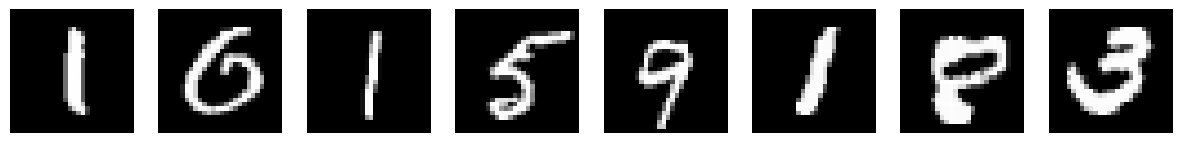

In [3]:
''' visualization '''

def show_images(images, nmax=8):
    fig, ax = plt.subplots(1, nmax, figsize=(15,3))
    for i in range(nmax):
        ax[i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        ax[i].axis('off')
    plt.show()

# Get one batch
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch)


<img  style = "height: 500px; display: flex; justify-content: center;" src = 'https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/vanilla-AE.png?size=630x472&lossy=2&strip=1&webp=1'>


Imagine we have a 28x28 pixel image. We save n features of this image, and later, we can reconstruct the image using just these features. There's a magical machine that knows how to extract these n features from the original image, and another machine that knows how to reconstruct the image based on those features. When training an AutoEncoder, these two machines, called the encoder and decoder, learn how to perform these operations.

The encoder learns how to compress the image into a smaller feature space, while the decoder learns how to reconstruct the original image from this compressed representation.

<h4 style = 'color: green'> Here you implement an AutoEncoder <h4>


In [4]:
''' AutoEncoder class '''

class AE(torch.nn.Module):
    def __init__(self, inputSize=784, hiddenSize=256, featureSize=64):
        super().__init__()

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, hiddenSize),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddenSize, featureSize)
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(featureSize, hiddenSize),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddenSize, inputSize),
            torch.nn.Sigmoid()  # Sigmoid -> because input is in [0,1]
        )

    def forward(self, x):
        # Flatten (B, 1, 28, 28) -> (B, 784)
        x = x.view(x.size(0), -1)
        # Encode
        z = self.encoder(x)
        # Decode
        out = self.decoder(z)
        # Reshape back to image
        out = out.view(x.size(0), 1, 28, 28)
        return out


Before we start training and evaluation, let's implement a variation of this model. During inference, in the traditional AutoEncoder, each image is mapped to a fixed vector of features, and the model is strict about this exact representation. Instead of using fixed numbers, we can keep a distribution, allowing for smoother interpolation in the feature space.

To achieve this, we introduce two vectors for each image: one representing the mean, and the other representing the log of the variance. Both vectors have the same size as the original feature space. In other words, we now have the parameters required to define a unique normal distribution for each image.

<img  style = "height: 500px; display: flex; justify-content: center;" src = 'https://github.com/bvezilic/Variational-autoencoder/raw/master/assets/VAE.001.jpeg'>


During decoding, instead of using a fixed feature vector, we sample from this distribution to build the features. This makes our model more flexible and generative, allowing it to create variations of images similar to those in the training dataset.

<div style="color: orange;">
  <h3>Now you might ask two questions:</h3>
  <ul>
    <li>Why do we keep the logarithm of the variance instead of the standard deviation?</li>
    <p>In short, it's due to numerical instability. If you're not convinced, you can check
      <a href="https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig" style="color: blue;">here</a>.
    </p>
    <li>How and where do we reparameterize?</li>
    <p>All you need to do during reparameterization is to compute the standard deviation using the formula:</p>
    <p style="font-weight: bold; text-align: center;">std = e<sup>0.5 * logvar</sup></p>
    <p>This can be implemented in the reparameterization function within the class below.</p>
  
  </ul>
</div>


<h4 style = 'color: green'> Now you implement a Variational AutoEncoder <h4>


In [9]:
''' Variational AutoEncoder class '''

class VAE(torch.nn.Module):
    def __init__(self, inputSize=784, hiddenSize=256, featureSize=64):
        super().__init__()

        # Encoder -> outputs both mu and logvar
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, hiddenSize),
            torch.nn.ReLU()
        )
        self.fc_mu     = torch.nn.Linear(hiddenSize, featureSize)
        self.fc_logvar = torch.nn.Linear(hiddenSize, featureSize)

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(featureSize, hiddenSize),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddenSize, inputSize),
            torch.nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # std = exp(0.5 * logvar)
        std = torch.exp(0.5 * logvar)
        # eps ~ N(0,1)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Flatten
        x = x.view(x.size(0), -1)
        # Encode
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Sample z
        z = self.reparameterize(mu, logvar)

        # Decode
        out = self.decoder(z)
        out = out.view(x.size(0), 1, 28, 28)
        return out, mu, logvar

<h4 style = 'color: green'> Here, we first train the AE and then the VAE <h4>


In [7]:
''' Train loop '''
def train_ae(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)

            # Forward
            reconstructed = model(images)
            loss = criterion(reconstructed, images)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")


# Instantiate and train
ae_model = AE(inputSize=784, hiddenSize=256, featureSize=64).to(device)
optimizer_ae = torch.optim.Adam(ae_model.parameters(), lr=lr)
mse_loss = torch.nn.MSELoss()

train_ae(ae_model, train_loader, optimizer_ae, mse_loss, epochs=30)


Epoch [1/30], Loss: 0.0307
Epoch [2/30], Loss: 0.0111
Epoch [3/30], Loss: 0.0081
Epoch [4/30], Loss: 0.0067
Epoch [5/30], Loss: 0.0057
Epoch [6/30], Loss: 0.0050
Epoch [7/30], Loss: 0.0046
Epoch [8/30], Loss: 0.0042
Epoch [9/30], Loss: 0.0040
Epoch [10/30], Loss: 0.0037
Epoch [11/30], Loss: 0.0035
Epoch [12/30], Loss: 0.0034
Epoch [13/30], Loss: 0.0033
Epoch [14/30], Loss: 0.0032
Epoch [15/30], Loss: 0.0031
Epoch [16/30], Loss: 0.0030
Epoch [17/30], Loss: 0.0029
Epoch [18/30], Loss: 0.0029
Epoch [19/30], Loss: 0.0028
Epoch [20/30], Loss: 0.0028
Epoch [21/30], Loss: 0.0028
Epoch [22/30], Loss: 0.0027
Epoch [23/30], Loss: 0.0027
Epoch [24/30], Loss: 0.0027
Epoch [25/30], Loss: 0.0026
Epoch [26/30], Loss: 0.0026
Epoch [27/30], Loss: 0.0026
Epoch [28/30], Loss: 0.0026
Epoch [29/30], Loss: 0.0026
Epoch [30/30], Loss: 0.0026


Implement a function that takes the model and the number of images as inputs, samples random images from your test dataset, and displays both the original and reconstructed images.

Original:


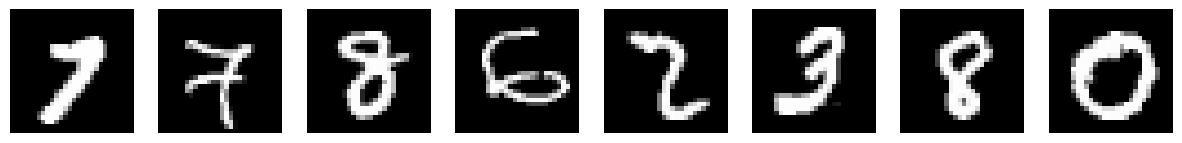

Reconstructed:


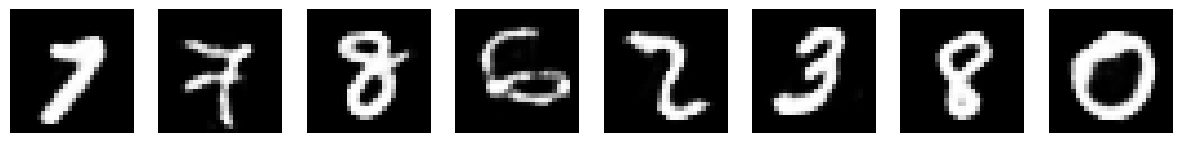

In [8]:
''' evaluation '''

def visualize_reconstruction(model, loader, n_images=8):
    model.eval()
    images, _ = next(iter(loader))  # just one batch
    images = images.to(device)
    with torch.no_grad():
        recon = model(images)

    # Move back to CPU for plotting
    images = images.cpu()
    recon = recon.cpu()

    # Plot original
    print("Original:")
    show_images(images, n_images)

    # Plot reconstructed
    print("Reconstructed:")
    show_images(recon, n_images)

visualize_reconstruction(ae_model, test_loader, n_images=8)

<h4 style = 'color: green'> Now we do exactly the same but this time for the VAE <h4>


Here, KL is a good choice, so we consider this loss with the proper weight in our training loop.

The KL (Kullback-Leibler) loss measures the difference between two probability distributions. In Variational Autoencoders (VAEs), KL loss ensures that the learned latent space follows a standard normal distribution.

The formula for KL loss is:

$
\text{KL}(q(z \mid x) \| p(z)) = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$


In [10]:
''' Train loop '''

def vae_loss(recon, x, mu, logvar):
    # MSE (or could be BCE) for reconstruction
    recon_loss = F.mse_loss(recon, x, reduction='sum')  # sum over batch

    # KL divergence
    # kl = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl, recon_loss, kl


def train_vae(model, loader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        for images, _ in loader:
            images = images.to(device)

            recon, mu, logvar = model(images)
            loss, recon_loss, kl = vae_loss(recon, images, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss   += loss.item()
            total_recon  += recon_loss.item()
            total_kl     += kl.item()

        avg_loss   = total_loss / len(loader.dataset)
        avg_recon  = total_recon / len(loader.dataset)
        avg_kl     = total_kl / len(loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}]  Total: {avg_loss:.4f}  "
              f"Recon: {avg_recon:.4f}  KL: {avg_kl:.4f}")


# Instantiate and train
vae_model = VAE(inputSize=784, hiddenSize=256, featureSize=64).to(device)
optimizer_vae = torch.optim.Adam(vae_model.parameters(), lr=lr)

train_vae(vae_model, train_loader, optimizer_vae, epochs=30)

Epoch [1/30]  Total: 47.1860  Recon: 41.5126  KL: 5.6734
Epoch [2/30]  Total: 37.9362  Recon: 28.7666  KL: 9.1696
Epoch [3/30]  Total: 34.9114  Recon: 24.8012  KL: 10.1102
Epoch [4/30]  Total: 33.4638  Recon: 22.8343  KL: 10.6295
Epoch [5/30]  Total: 32.6665  Recon: 21.6923  KL: 10.9742
Epoch [6/30]  Total: 32.1101  Recon: 20.9587  KL: 11.1514
Epoch [7/30]  Total: 31.7818  Recon: 20.4465  KL: 11.3353
Epoch [8/30]  Total: 31.5425  Recon: 20.0661  KL: 11.4764
Epoch [9/30]  Total: 31.3164  Recon: 19.7514  KL: 11.5650
Epoch [10/30]  Total: 31.1452  Recon: 19.4858  KL: 11.6594
Epoch [11/30]  Total: 30.9963  Recon: 19.2880  KL: 11.7083
Epoch [12/30]  Total: 30.8666  Recon: 19.1234  KL: 11.7432
Epoch [13/30]  Total: 30.7634  Recon: 18.9783  KL: 11.7851
Epoch [14/30]  Total: 30.6391  Recon: 18.8496  KL: 11.7895
Epoch [15/30]  Total: 30.5424  Recon: 18.7219  KL: 11.8205
Epoch [16/30]  Total: 30.4883  Recon: 18.6420  KL: 11.8463
Epoch [17/30]  Total: 30.3948  Recon: 18.5249  KL: 11.8699
Epoch [1

Same as you did, compare the constructed images and original ones but this time with the VAE model

Original:


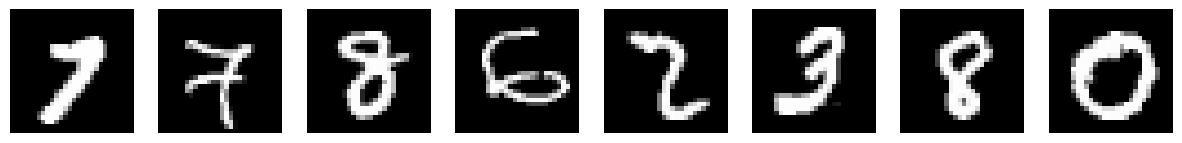

Reconstructed:


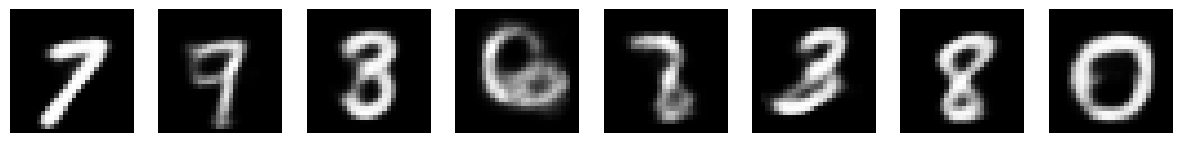

In [11]:
''' evaluation '''
def visualize_vae_reconstruction(model, loader, n_images=8):
    model.eval()
    images, _ = next(iter(loader))
    images = images.to(device)
    with torch.no_grad():
        recon, mu, logvar = model(images)
    images = images.cpu()
    recon = recon.cpu()

    print("Original:")
    show_images(images, n_images)

    print("Reconstructed:")
    show_images(recon, n_images)

visualize_vae_reconstruction(vae_model, test_loader, n_images=8)

This time, we modify the VAE to process the input using convolutional layers. Implement a convolutional VAE with an architecture of your choice, but keep it as simple as possible.

In [12]:
class CNNVAE(torch.nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()

        # -------------------
        # ENCODER
        # -------------------
        # (B, 1, 28, 28)
        self.encoderConv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> (B, 32, 14, 14)
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (B, 64, 7, 7)
            torch.nn.ReLU()
        )

        # Flatten (64*7*7 = 3136)
        self.fc_mu     = torch.nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = torch.nn.Linear(64*7*7, latent_dim)

        # -------------------
        # DECODER
        # -------------------
        self.decoderInput = torch.nn.Linear(latent_dim, 64*7*7)

        # Convert back to (B,64,7,7) then do transpose conv
        self.decoderConv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (B,32,14,14)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (B,1,28,28)
            torch.nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        x_enc = self.encoderConv(x)
        x_enc = x_enc.view(x_enc.size(0), -1)  # flatten
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)

        # Sample in latent space
        z = self.reparameterize(mu, logvar)

        # Decode
        x_dec = self.decoderInput(z)
        x_dec = x_dec.view(-1, 64, 7, 7)
        x_dec = self.decoderConv(x_dec)

        return x_dec, mu, logvar

Train your convolutional VAE model (same as you did for VAE)

In [13]:
''' Train loop '''

cnn_vae_model = CNNVAE(latent_dim=20).to(device)
optimizer_cnn_vae = torch.optim.Adam(cnn_vae_model.parameters(), lr=lr)

train_vae(cnn_vae_model, train_loader, optimizer_cnn_vae, epochs=30)

Epoch [1/30]  Total: 45.0587  Recon: 35.3391  KL: 9.7196
Epoch [2/30]  Total: 33.7030  Recon: 21.4743  KL: 12.2287
Epoch [3/30]  Total: 32.2837  Recon: 19.6663  KL: 12.6174
Epoch [4/30]  Total: 31.6690  Recon: 18.9115  KL: 12.7574
Epoch [5/30]  Total: 31.2714  Recon: 18.4882  KL: 12.7832
Epoch [6/30]  Total: 31.0238  Recon: 18.2135  KL: 12.8102
Epoch [7/30]  Total: 30.7334  Recon: 17.9605  KL: 12.7729
Epoch [8/30]  Total: 30.5529  Recon: 17.7919  KL: 12.7610
Epoch [9/30]  Total: 30.3775  Recon: 17.6340  KL: 12.7435
Epoch [10/30]  Total: 30.2196  Recon: 17.5030  KL: 12.7166
Epoch [11/30]  Total: 30.0745  Recon: 17.3903  KL: 12.6842
Epoch [12/30]  Total: 29.9779  Recon: 17.2819  KL: 12.6960
Epoch [13/30]  Total: 29.8666  Recon: 17.1864  KL: 12.6801
Epoch [14/30]  Total: 29.7743  Recon: 17.1224  KL: 12.6519
Epoch [15/30]  Total: 29.7028  Recon: 17.0217  KL: 12.6811
Epoch [16/30]  Total: 29.6357  Recon: 16.9763  KL: 12.6594
Epoch [17/30]  Total: 29.5334  Recon: 16.8718  KL: 12.6615
Epoch [

Compare the reconstructed and original images as you did before, but for the model you have just trained

Original:


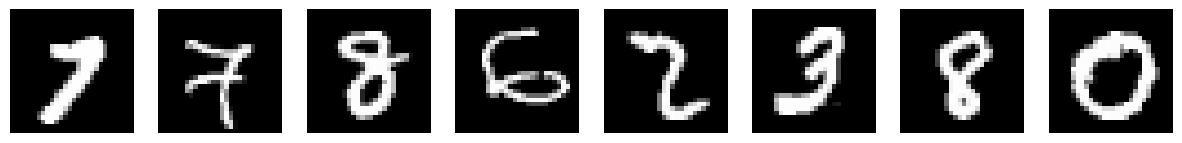

Reconstructed:


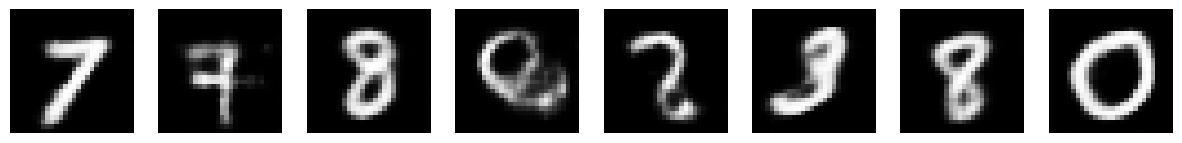

In [14]:
''' evaluation '''
def visualize_cnn_vae_reconstruction(model, loader, n_images=8):
    model.eval()
    images, _ = next(iter(loader))
    images = images.to(device)
    with torch.no_grad():
        recon, mu, logvar = model(images)
    images = images.cpu()
    recon = recon.cpu()

    print("Original:")
    show_images(images, n_images)

    print("Reconstructed:")
    show_images(recon, n_images)

visualize_cnn_vae_reconstruction(cnn_vae_model, test_loader, n_images=8)
